In [1]:
%matplotlib inline

import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

sns.set_context("poster")
sns.set_style("white")

# CNN CIFAR10

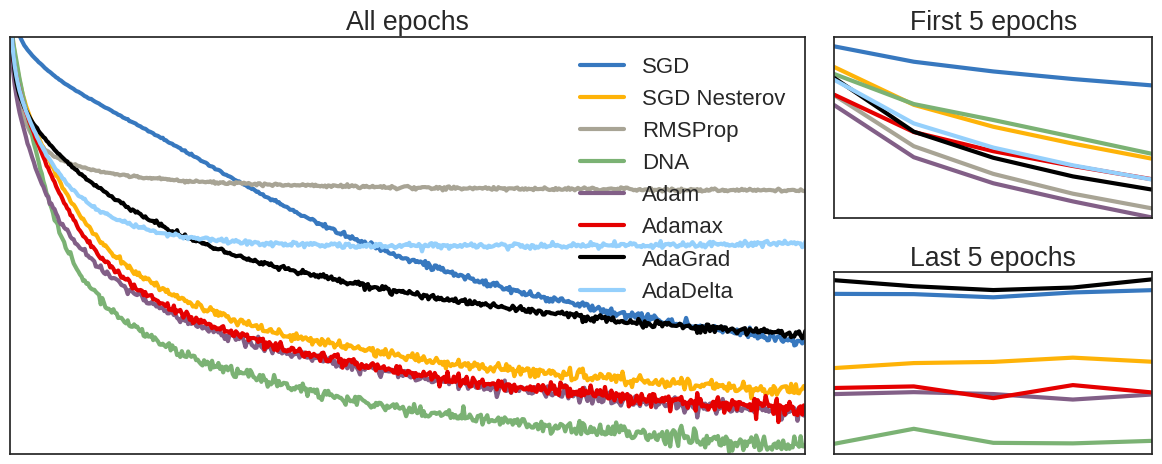

In [2]:
opt_titles = [
    ("sgd", "SGD"),
    ("sgdnesterov", "SGD Nesterov"),
    ("rmsprop", "RMSProp"),
    ("dna", "DNA"),
    ("adam", "Adam"),
    ("adamax", "Adamax"),
    ("adagrad", "AdaGrad"),
    ("adadelta", "AdaDelta")
]
colors = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple", "red", "black", "light blue"])

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

for i, (opt, title) in enumerate(opt_titles):
    with open("../data/cnn/cifar10/{}.pkl".format(opt), "rb") as f:
        loss_history = pickle.load(f)["best_loss_history"]
    ax1.semilogy(range(1, len(loss_history) + 1), loss_history, label=title, color=colors[i], linewidth=3)
    ax2.semilogy(range(1, 6), loss_history[:5], color=colors[i], linewidth=3)
    ax3.semilogy(range(496, 501), loss_history[-5:], color=colors[i], linewidth=3)

for ax in [ax1, ax2, ax3]:
    ax.get_yaxis().get_major_formatter().labelOnlyBase = False
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())


ax1.set_ylim(0.017, 1.7)
ax1.set_title("All epochs")
ax1.legend()

ax2.set_ylim(0.8, 2.4)
ax2.set_title("First 5 epochs")

ax3.set_ylim(0.017, 0.07)
ax3.set_title("Last 5 epochs")

for ax in [ax1, ax2, ax3]:
    ax.set_yticks([])
    ax.set_xticks([])
fig.tight_layout()

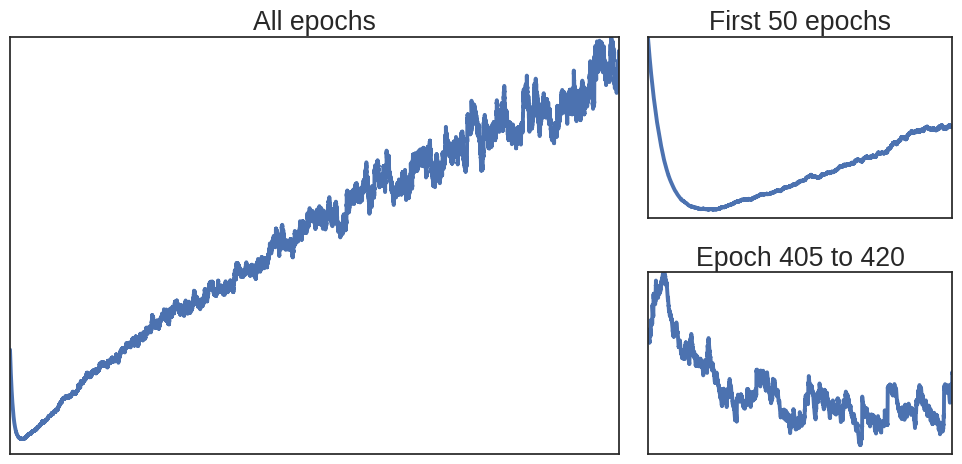

In [3]:
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

with open("../data/cnn/cifar10/dna.pkl", "rb") as f:
    dna_ds = np.array([x.item() for x in pickle.load(f)["ds"]])
epoch_nums = np.arange(1, len(dna_ds) + 1) * 128. / 50000

ax1.plot(epoch_nums, dna_ds)
ax1.set_xlim(0, 500)
ax1.set_ylim(0, 4)
ax1.set_title("All epochs")

ax2.plot(epoch_nums[epoch_nums <= 50], dna_ds[epoch_nums <= 50])
ax2.set_xlim(0, 50)
ax2.set_title("First 50 epochs")

ax3_epoch_range = np.bitwise_and(epoch_nums >= 405, epoch_nums <= 420)
ax3.plot(epoch_nums[ax3_epoch_range], dna_ds[ax3_epoch_range])
ax3.set_ylim([2.9, 3.5])
ax3.set_xlim(405, 420)
ax3.set_title("Epoch 405 to 420")

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

# CNN CIFAR100

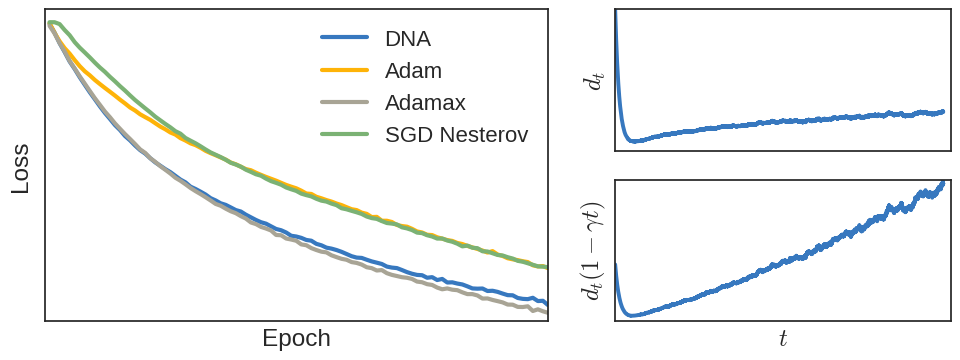

In [4]:
opt_titles = [
    ("dna", "DNA"),
    ("adam", "Adam"),
    ("adamax", "Adamax"),
    ("sgdnesterov", "SGD Nesterov")
]
colors = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green"])

fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(2, 2, width_ratios=[1.5, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

for i, (opt, title) in enumerate(opt_titles):
    with open("../data/big_cnn/cifar100/{}.pkl".format(opt), "rb") as f:
        loss_history = pickle.load(f)["best_loss_history"]
    ax1.semilogy(range(1, len(loss_history) + 1), loss_history, label=title, color=colors[i], linewidth=3)

ax1.get_yaxis().get_major_formatter().labelOnlyBase = False
ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_ylim(0.7, 5)
ax1.legend()

with open("../data/big_cnn/cifar100/dna.pkl", "rb") as f:
    dna_data = pickle.load(f)
ds = np.array([x.item() for x in dna_data["ds"]])
decays = 1. + (dna_data["best_opt_config"]["decay"] * np.arange(1, len(ds) + 1))

ax2.plot(ds, color=colors[0])
ax2.set_ylabel("$d_t$")
ax3.plot(ds * decays, color=colors[0])
ax3.set_ylabel("$d_t(1 - \gamma t)$")
ax3.set_xlabel("$t$")

for ax in [ax1, ax2, ax3]:
    ax.set_yticks([])
    ax.set_xticks([])
fig.tight_layout()